In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

import time
import warnings
warnings.simplefilter("ignore", UserWarning)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 256
workers = 8

## MNIST dataset

In [3]:
dataroot = './data/mnist'

transform_train = transforms.Compose([transforms.ToTensor()])

transform_test = transforms.Compose([transforms.ToTensor()])

dataset_train = torchvision.datasets.MNIST(dataroot, train=True, download=True, transform=transform_train)
dataset_test = torchvision.datasets.MNIST(dataroot, train=False, download=True, transform=transform_test)

# Create the dataloaders
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

testloader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!


## ConvNet 1



In [0]:
class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,64,5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64,64,5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(1024,128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128,10),
            nn.Softmax()
        )
        
    def forward(self,x):
        bsize = x.size(0) # taille du batch
        output = self.features(x) # on calcule la sortie des conv
        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input
        output = self.classifier(output)
        return output

## Train ConvNet

In [0]:
convnet1 = ConvNet1()
convnet1.to(device)

criterion = nn.CrossEntropyLoss()
lr_conv1 = 1e-3
optimizer = torch.optim.Adam(convnet1.parameters(), lr_conv1)
epochs = 30

c1_train_loss = []
c1_test_loss = []
c1_train_prec = []
c1_test_prec = []
c1_mean_train_loss = []
c1_mean_test_loss = []

best_state_dict = ([], 0.0)

nb_train = len(dataset_train)
nb_test = len(dataset_test)

In [7]:
print("Training Begin")
for ep in range(epochs):

    sum_train = 0
    sum_test = 0
    c1_train_loss = []
    c1_test_loss = []
    print("\nepoch:", ep)
    convnet1.train()

    for i, (x, y) in enumerate(trainloader):
        y = y.to(device)

        optimizer.zero_grad()
        output = convnet1(x.to(device))
        loss = criterion(output, y)
        c1_train_loss.append(float(loss))
        sum_train += int(torch.sum(torch.argmax(output, 1) == y))
        loss.backward()
        optimizer.step()

    
    c1_mean_train_loss.append(sum(c1_train_loss)/len(c1_train_loss))
    print("train : loss =", round(c1_mean_train_loss[-1],6), 'precision =' ,round(sum_train/nb_train, 3))
    c1_train_prec.append(sum_train/nb_train)

    convnet1.eval()
    for i,(x,y) in enumerate(testloader):
        with torch.no_grad():

            y = y.to(device)
            output = convnet1(x.to(device))
            loss = criterion(output, y.view(-1))
            c1_test_loss.append(float(loss))
            sum_test += int(torch.sum(torch.argmax(output,1)==y))

    
    c1_mean_test_loss.append(sum(c1_test_loss)/len(c1_test_loss))
    print("test : loss =", round(c1_mean_test_loss[-1],6), 'precision =' ,round(sum_test/nb_test, 3))
    c1_test_prec.append(sum_test/nb_test)

    if c1_test_prec[-1] > best_state_dict[1]:
        best_state_dict = (convnet1.state_dict(), c1_test_prec[-1])

    if len(c1_mean_test_loss) > 3 and c1_mean_test_loss[-1] > sum(c1_mean_test_loss[-3:-1])/2:
        print("End training")
        torch.save(best_state_dict[0], 'convnet_cifar10.cpkt')
        print('convnet save, convnet_cifar10.cpkt')
        break


Training Begin

epoch: 0
train : loss = 1.612817 precision = 0.859
test : loss = 1.493382 precision = 0.97

epoch: 1
train : loss = 1.504181 precision = 0.96
test : loss = 1.482338 precision = 0.979

epoch: 2
train : loss = 1.493368 precision = 0.97
test : loss = 1.477324 precision = 0.984

epoch: 3
train : loss = 1.487545 precision = 0.975
test : loss = 1.47453 precision = 0.987

epoch: 4
train : loss = 1.483458 precision = 0.979
test : loss = 1.473656 precision = 0.988

epoch: 5
train : loss = 1.481925 precision = 0.98
test : loss = 1.471915 precision = 0.989

epoch: 6
train : loss = 1.479949 precision = 0.982
test : loss = 1.47296 precision = 0.991
End training
convnet save, convnet_cifar10.cpkt


## Architecture pour le générateur pour Mnist

In [0]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            
            nn.Conv2d(16,32,3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.Conv2d(32,32,3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32,32,3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32,16,3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),

            nn.Conv2d(16,2,3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(2),

            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
    def forward(self,x):
        return self.encoder(x)
        

class Decoder(nn.Module):
  def __init__ (self): 
        super(Decoder,self).__init__()       
        self.decoder = nn.Sequential(
            nn.Conv2d(2,32,3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32,32,3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.ConvTranspose2d(32,64,3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.Conv2d(64,64,3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.Conv2d(64,64,3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64,16,3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),

            nn.Conv2d(16,1,1, padding=1)  
        )
        
  def forward(self,z):
      return torch.tanh(self.decoder(z))

In [0]:
class MarginLoss(nn.Module):

    def __init__(self, margin=200, target=False):
        """
            margin : κ is the margin parameter that can be used to adjust 
                     transfer-ability of the generator. A higher value of κ leads to 
                     higher transferability to other models 

            target: si l'attaque est targeté ou non.
        """
        super(MarginLoss, self).__init__()
        self.margin = margin
        self.target = target

    def forward(self, logits, label):

        if not self.target:
            one_hot= torch.zeros_like(logits, dtype=torch.uint8)
            label = label.reshape(-1,1)
            one_hot.scatter_(1, label, 1)
            diff = logits[one_hot] - torch.max(logits[~one_hot].view(len(logits),-1), dim=1)[0]
            margin = torch.nn.functional.relu(diff + self.margin, True) - self.margin
        else:
            diff = torch.max(torch.cat((logits[:, :label],logits[:,(label+1):]), dim=1), dim=1)[0] - logits[:, label]
            margin = torch.nn.functional.relu(diff + self.margin, True) - self.margin
        return margin.mean()

## Train du générateur

Sur MNIST avec ConvNet comme Model white-box

In [0]:
epochs = 300

learning_rate = 0.1
gamma = 0.5
momentum = 0.9
decay = 0.0005
epsilon = 0.03


convnet = ConvNet1()
convnet.to(device)
convnet.load_state_dict(torch.load('convnet_cifar10.cpkt'))

convnet.eval()

Generator = nn.Sequential(
    Encoder(),
    Decoder()
)

Generator.to(device)


optimizer_G = torch.optim.SGD(Generator.parameters(), learning_rate, momentum,
                            weight_decay=decay, nesterov=True)

scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=50,
                                            gamma=gamma)

hingeloss = MarginLoss(margin=200, target=False) 


c1_train_loss = []
c1_test_loss = []
c1_train_prec = []
c1_test_prec = []
c1_mean_train_loss = []
c1_mean_test_loss = []

moy_sec = 0

best_state_dict = ([], 0.0)

nb_train = len(dataset_train)
nb_test = len(dataset_test)


batch = next(iter(trainloader))
fixe_x = batch[0].to(device)[:16]

Training Begin


epoch: 1
train : loss = -0.010885 precision = 0.984883
durée moyenne d'une epoch = 14.0576 | Temps restant = 70.054


epoch: 2
train : loss = -0.011274 precision = 0.984333
durée moyenne d'une epoch = 14.13105 | Temps restant = 70.184


epoch: 3
train : loss = -0.01134 precision = 0.9843
durée moyenne d'une epoch = 14.191066666666666 | Temps restant = 70.246


epoch: 4
train : loss = -0.010684 precision = 0.98495
durée moyenne d'une epoch = 14.1744 | Temps restant = 69.927


epoch: 5
train : loss = -0.011072 precision = 0.98465
durée moyenne d'une epoch = 14.15162 | Temps restant = 69.579


epoch: 6
train : loss = -0.009668 precision = 0.986483
durée moyenne d'une epoch = 14.1323 | Temps restant = 69.248


epoch: 7
train : loss = -0.007769 precision = 0.98895
durée moyenne d'une epoch = 14.129328571428573 | Temps restant = 68.998


epoch: 8
train : loss = -0.00763 precision = 0.98925
durée moyenne d'une epoch = 14.120475 | Temps restant = 68.72


epoch: 9
train : loss 

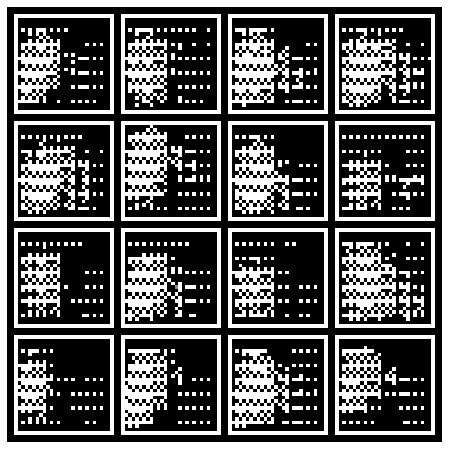

Generator is save
durée moyenne d'une epoch = 14.28068 | Temps restant = 69.023


epoch: 11
train : loss = -0.007992 precision = 0.988633
durée moyenne d'une epoch = 14.254009090909092 | Temps restant = 68.657


epoch: 12
train : loss = -0.008651 precision = 0.9876
durée moyenne d'une epoch = 14.230058333333334 | Temps restant = 68.304


epoch: 13
train : loss = -0.008396 precision = 0.9877
durée moyenne d'une epoch = 14.20499230769231 | Temps restant = 67.947


epoch: 14
train : loss = -0.007979 precision = 0.988733
durée moyenne d'une epoch = 14.184257142857145 | Temps restant = 67.612


epoch: 15
train : loss = -0.009113 precision = 0.9872
durée moyenne d'une epoch = 14.164073333333334 | Temps restant = 67.279


epoch: 16


KeyboardInterrupt: ignored

In [15]:
print("Training Begin")
for ep in range(1, epochs):
    start_time = time.time()

    sum_train = 0
    sum_test = 0
    c1_train_loss = []
    c1_test_loss = []


    print("\n\nepoch:", ep)
    
    #scheduler_G.step()

    for i, (x, y) in enumerate(trainloader):

        Generator.train()
        convnet.eval()


        y = y.to(device)
        x = x.to(device)
    
        output = Generator(x)

        adv = torch.clamp(output * epsilon + x, 0, 1)
        logits_adv = convnet(adv)
        loss = hingeloss(logits_adv, y)
        c1_train_loss.append(float(loss))
        sum_train += int(torch.sum(torch.argmax(logits_adv, 1) == y))

        loss.backward()
        optimizer_G.step()

    c1_mean_train_loss.append(sum(c1_train_loss)/len(c1_train_loss))
    print("train : loss =", round(c1_mean_train_loss[-1],6), 'precision =' ,round(sum_train/nb_train, 6))
    c1_train_prec.append(sum_train/nb_train)

    torch.cuda.empty_cache()
    loss_avg = 0.0

    if ep % 10 == 0:
        for i,(x,y) in enumerate(testloader):
            Generator.eval()

            with torch.no_grad():
                y = y.to(device)
                x = x.to(device)

                output = Generator(x)
                adv = torch.clamp(output * epsilon + x, 0, 1)
                logits_adv = convnet(adv)
                loss = hingeloss(logits_adv, y)
                c1_test_loss.append(float(loss))

                sum_test += int((torch.argmax(logits_adv, 1) == y).sum())        
        
        c1_mean_test_loss.append(sum(c1_test_loss)/len(c1_test_loss))
        print("test : loss =", round(c1_mean_test_loss[-1],6), 'precision =' ,round(sum_test/nb_test, 6))
        c1_test_prec.append(sum_test/nb_test)

        output = Generator(fixe_x)
        plt.figure(figsize=(8,8))
        plt.imshow(np.transpose(torchvision.utils.make_grid(output, padding=2, normalize=True, nrow=4).cpu().detach().numpy(),(1,2,0)))
        plt.axis("off")
        plt.show()
    
        if c1_test_prec[-1] > best_state_dict[1]:
            print('Generator is save')
            best_state_dict = (Generator.state_dict(), c1_test_prec[-1])
            torch.save(best_state_dict[0], 'generator.cpkt')


    end_time = time.time()
    moy_sec += round(end_time - start_time, 4)
    print("durée moyenne d'une epoch =", moy_sec/ep, "| Temps restant =", round((moy_sec/ep*(epochs-ep)) / 60, 3))

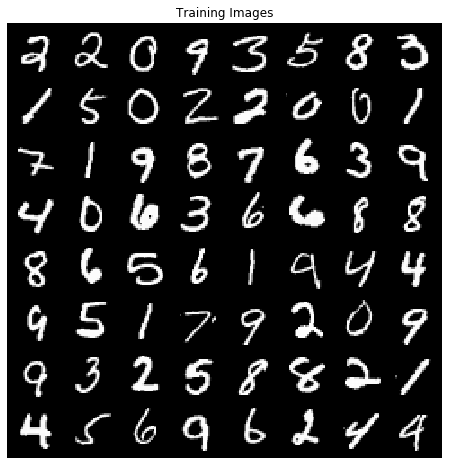

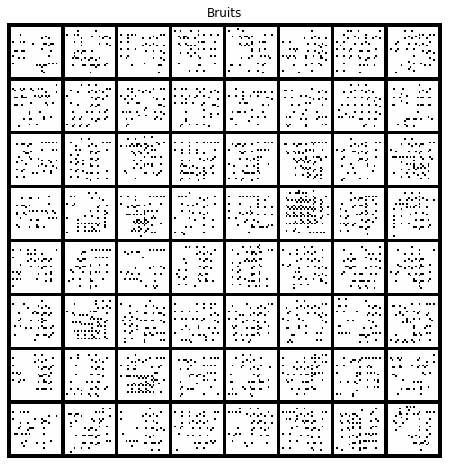

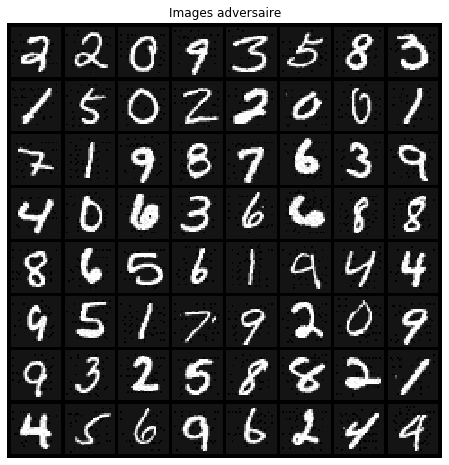

In [23]:
batch = next(iter(trainloader))

x = batch[0].to(device)[:64]
output = Generator(x)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(x, padding=2, normalize=True, nrow=8).cpu().detach().numpy(),(1,2,0)))
plt.show()

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Bruits")
plt.imshow(np.transpose(torchvision.utils.make_grid(output, padding=2, normalize=True, nrow=8).cpu().detach().numpy(),(1,2,0)))
plt.show()

adv = torch.clamp(output * 0.08 + x, 0, 1)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Images adversaire")
plt.imshow(np.transpose(torchvision.utils.make_grid(adv, padding=2, normalize=True, nrow=8).cpu().detach().numpy(),(1,2,0)))
plt.show()